In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Load data
data = pd.read_csv('2014_2020_all_tract.csv')

# Remove negative values for SVI variables
data.drop(data[data['overall_svi'] < 0].index, axis=0, inplace=True)
data.drop(['FIPS.1', 'year.1'], axis=1, inplace=True)

data.describe()

,longitude,latitude,FIPS,avg_co2,year,ST,STCNTY,total_population,housing_units,num_households,...,overall_svi,xco2_std,co2_1yr_change,co2_6yr_change,co2_1yr_pct_change,co2_6yr_pct_change,co2_5yr_pct_change,co2_4yr_pct_change,co2_3yr_pct_change,co2_2yr_pct_change
count,481356.000000,481356.000000,4.813560e+05,481356.000000,481356.000000,481356.000000,481356.000000,481356.000000,481356.000000,481356.000000,...,481356.000000,481356.000000,409508.000000,61497.000000,409508.000000,61497.000000,122112.000000,193953.000000,265813.000000,337669.000000
mean,-91.338791,37.891423,2.785289e+10,405.293959,2016.881645,27.766719,27852.635862,4300.937201,1821.007041,1599.736943,...,0.504423,2.237366,0.010997,0.146357,0.000203,0.000548,0.000177,-0.000134,-0.000084,0.000107
std,15.777743,5.080544,1.581195e+10,5.049527,1.967553,15.788303,15811.944530,2033.852703,819.138212,726.822753,...,0.287549,0.562420,7.592208,7.715505,0.018734,0.019057,0.020154,0.019005,0.019149,0.018507
min,-167.500000,25.500000,1.001020e+09,395.892359,2014.000000,1.000000,1001.000000,3.000000,0.000000,0.000000,...,0.000000,0.906687,-16.194244,-16.096046,-0.039197,-0.039042,-0.039342,-0.039213,-0.039062,-0.039310
25%,-97.500000,34.500000,1.211991e+10,400.472697,2015.000000,12.000000,12119.000000,2901.000000,1266.000000,1098.500000,...,0.256200,1.728153,-5.931938,-6.004117,-0.014680,-0.014815,-0.015951,-0.014315,-0.014632,-0.013938
50%,-86.500000,38.500000,2.713908e+10,405.795074,2017.000000,27.000000,27139.000000,4040.000000,1717.000000,1514.000000,...,0.505900,2.251890,1.928314,1.819606,0.004833,0.004482,0.004508,-0.005109,-0.004439,-0.004226
75%,-79.500000,41.500000,4.103196e+10,409.961034,2019.000000,41.000000,41031.000000,5359.500000,2249.500000,1994.000000,...,0.754100,2.727143,5.943428,5.799454,0.014863,0.014594,0.016814,0.014356,0.014554,0.014229
max,-67.500000,64.500000,5.604595e+10,414.554260,2020.000000,56.000000,56045.000000,70271.000000,26436.000000,21337.000000,...,1.000000,3.853587,16.137922,16.137922,0.040699,0.040620,0.040918,0.040650,0.040814,0.040830


In [2]:
data.columns

Index(['longitude', 'latitude', 'FIPS', 'avg_co2', 'year', 'ST', 'STATE',
       'ST_ABBR', 'STCNTY', 'COUNTY', 'LOCATION', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std', 'co2_1yr_change', 'co2_6yr_change', 'co2_1yr_pct_change',
       'co2_6yr_pct_change', 'co2_5yr_pct_change', 'co2_4yr_pct_change',
       'co2_3yr_pct_change', 'co2_2yr_pct_change'],
      dtype='object')

## Sample dataset and fit DBSCAN using temporal features

To examine the temporal features, we subset the dataset and run DBSCAN with the 'co2_6yr_pct_change' column which represents the total percentage change in CO2 values across the time period.

In [3]:
# Subset dataset

df_6yr_pct_change = data[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std', 'co2_6yr_pct_change']]

In [4]:
# Drop NaN values 
df_6yr_pct_change = df_6yr_pct_change.dropna(axis=0)

In [5]:
# Check shape of the df
df_6yr_pct_change.shape

(61497, 12)

In [6]:
# Scaling the data
# initialize scaler
scaler = StandardScaler()

scaled_df_6yr_pct_change = df_6yr_pct_change.copy()

# scale the data
scaled_df_6yr_pct_change  = pd.DataFrame(scaler.fit_transform(scaled_df_6yr_pct_change))

# rename columns
scaled_df_6yr_pct_change.columns = df_6yr_pct_change.columns

In [7]:
# Sample to test for DBSCAN eps and min_sample values
scaled_df_6yr_pct_change_sample = scaled_df_6yr_pct_change.sample(30000)

In [36]:
# Epsilon values
x = np.linspace(1.0, 2.0, 5)

# Min core points
min_samples = list(range(5,11))

epsilon = []
m_samples = []
sil_scores = []
n_clusters = []


for eps in x:
    for samples in min_samples:
        df_copy = scaled_df_6yr_pct_change_sample.copy()
        # fit dbscan model
        dbscan = DBSCAN(eps = eps, min_samples = samples)
        dbscan.fit(df_copy)

        # add cluster labels to df
        df_copy['Cluster']=dbscan.labels_
        labels = dbscan.labels_
        n_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in labels else 0))
        # print(n_clusters)

        # measure silhouette score
        if n_clusters[-1] == 0:
            sil_scores.append(0)
        else:
            sil_scores.append(metrics.silhouette_score(df_copy, labels))
        epsilon.append(eps)
        m_samples.append(samples)

In [37]:
dbscan_6yr_pct_change_sample = pd.DataFrame(data={'Epsilon': epsilon, 'Min_samples': m_samples, 'Silhouette Scores': sil_scores, 'Num of Clusters': n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_6yr_pct_change_sample.loc[dbscan_6yr_pct_change_sample['Silhouette Scores'].idxmax()]

Epsilon              2.000000
Min_samples          5.000000
Silhouette Scores    0.368351
Num of Clusters      2.000000
Name: 24, dtype: float64

In [38]:
print(dbscan_6yr_pct_change_sample.to_string())

    Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0      1.00            5          -0.086437              245
1      1.00            6          -0.088215              154
2      1.00            7          -0.014400              141
3      1.00            8          -0.000598              104
4      1.00            9          -0.015394               79
5      1.00           10           0.001714               67
6      1.25            5           0.067490               27
7      1.25            6           0.050970               17
8      1.25            7           0.015478               15
9      1.25            8           0.000612               14
10     1.25            9           0.047294               11
11     1.25           10           0.046491                9
12     1.50            5           0.032650                5
13     1.50            6           0.033462                5
14     1.50            7           0.034195                6
15     1.50            8

In [20]:
dbscan_6yr_pct_change = scaled_df_6yr_pct_change.copy()
dbscan = DBSCAN(eps = 2, min_samples = 8)
dbscan.fit(dbscan_6yr_pct_change)
# add cluster labels to df
dbscan_6yr_pct_change['Cluster']=dbscan.labels_
labels = dbscan.labels_
n_clusters=len(set(dbscan.labels_)) - (1 if -1 in labels else 0)
print(n_clusters)

# measure silhouette score
sil_dbscan_6yr_change = metrics.silhouette_score(dbscan_6yr_pct_change, labels)
print(sil_dbscan_6yr_change)

2
0.40379277794330276


In [21]:
dbscan_6yr_pct_change['Cluster'].value_counts()

 0    61163
-1      270
 1       64
Name: Cluster, dtype: int64

In [26]:
scaled_df_6yr_pct_change

,avg_co2,total_population,housing_units,num_households,unemployment,socioeconomic,household_comp,minority_status,housing_type,overall_svi,xco2_std,co2_6yr_pct_change
0,-0.412054,-0.465592,-0.866494,-0.742611,1.019416,0.649271,0.764385,1.048311,-1.236689,0.330020,0.725104,0.390893
1,-0.041144,-1.331474,-1.245262,-1.323215,-0.235594,1.617002,0.716756,-0.169350,0.039404,1.001136,0.975722,-0.921124
2,-1.127682,0.083983,-0.247684,-0.645843,0.575035,1.582124,1.298605,1.480933,1.233236,1.617346,1.295861,0.307059
3,0.619393,-0.712806,-0.796352,-0.656211,-0.719041,-0.854122,-1.502586,1.083379,-0.182980,-0.585749,-0.790149,-0.260654
4,1.368032,0.067502,0.684427,-0.058327,-0.377210,0.185968,0.862840,-1.385622,0.652179,0.382508,-0.036908,0.889126
...,...,...,...,...,...,...,...,...,...,...,...,...
61492,1.308674,1.779616,1.797349,2.129306,-0.426043,-1.620741,-0.246120,-0.023175,-1.523906,-1.488052,0.676756,0.818654
61493,0.549838,-0.741964,-0.676331,-0.578452,-0.543242,-0.452592,-0.823348,-1.185977,-0.761248,-0.981132,-0.823011,0.949617
61494,0.373777,-0.098574,-0.144809,-0.130903,1.029182,0.730479,0.689388,-0.908904,-1.130377,-0.132354,-0.328400,0.965017
61495,0.619393,-0.830074,-1.226557,-1.000081,-1.021806,-1.341024,-0.998222,1.214971,-1.448616,-1.138595,-0.790149,-0.260654


In [31]:
clusters = ['Cluster {}'.format(i) for i in range(-1,2)]
memb =  pd.Series(labels, index=scaled_df_6yr_pct_change.index)
# Centroids_orig = pd.DataFrame(0.0, index = clusters,columns = preprocess_df.columns)

Centroids_std = pd.DataFrame(0.0, index =  clusters,
                        columns = scaled_df_6yr_pct_change.columns)
for i in range(-1,2):
    BM = memb==i
    # Centroids_orig.iloc[i] = preprocess_df[BM].median(axis=0)
    Centroids_std.iloc[i] = scaled_df_6yr_pct_change[BM].mean(axis=0)

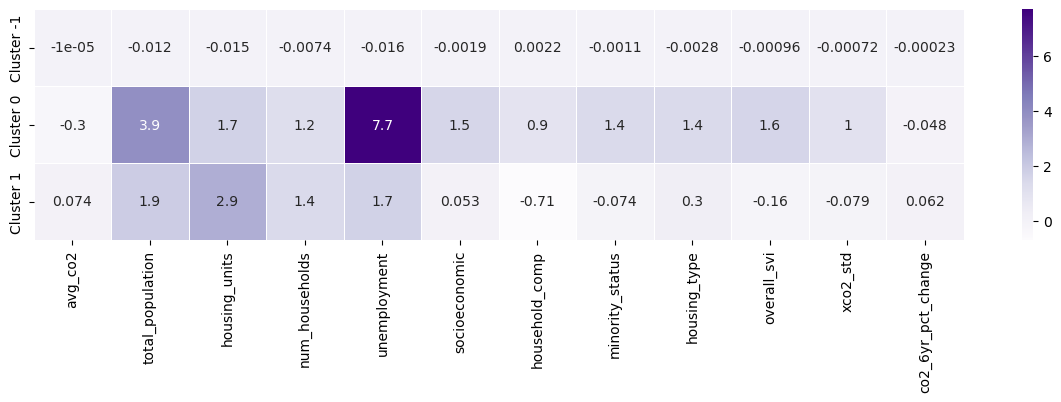

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
sns.heatmap(Centroids_std, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

## DBSCAN using multilevel indexing for all years of data

Instead of using temporal change features such as % change in CO2, here we implement DBSCAN with the whole dataset over the years using multilevel indexing on FIPS and year fields.

In [44]:
# Subset and scale the data
# initialize scaler
scaler = StandardScaler()

scaled_df_subset = data[['FIPS','avg_co2', 'xco2_std', 'year','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']].copy()


# scale the data
scaled_df_subset[['avg_co2', 'xco2_std','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']] = scaler.fit_transform(scaled_df_subset[['avg_co2', 'xco2_std','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']])


In [46]:
# Start by pivoting data
pivoted_df = scaled_df_subset[['FIPS','avg_co2', 'xco2_std', 'year','total_population', 'housing_units', 'num_households', 'unemployment','socioeconomic', 'household_comp', 'minority_status', 'housing_type']].pivot_table(index='FIPS', columns='year')
pivoted_df

avg_co2                                                    \
year             2014      2015      2016      2017      2018      2019   
FIPS                                                                      
1001020100  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020200  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020300  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020400  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020500  -1.544820 -1.000387 -0.360496  0.026080  0.462927       NaN   
...               ...       ...       ...       ...       ...       ...   
56043000200 -1.649210 -1.105089 -0.469222  0.086112  0.486832  0.947617   
56043000301 -1.600983 -1.086264 -0.485262  0.063353  0.481001  0.910583   
56043000302 -1.600983 -1.086264 -0.485262  0.063353  0.481001  0.910583   
56045951100 -1.620393 -1.088173 -0.422281  0.048533  0.432003  0.956676   
56045951300 -1.620393 -1.088173 -0.422281  0.048533  0.432003  0.956676   

                      household_comp                      ... unemployment  \
year             2020           2014      2015      2016  ...         2018   
FIPS                                                      ...                
1001020100   1.522620      -0.587399 -0.773455 -0.959510  ...    -1.031834   
1001020200   1.522620      -0.575693 -0.078008  0.419677  ...    -1.031834   
1001020300   1.522620       1.301534  0.972522  0.643511  ...    -0.855787   
1001020400   1.522620       1.047548  1.054820  1.062092  ...    -0.908601   
1001020500        NaN      -0.157468 -0.234799 -0.312130  ...    -0.459683   
...               ...            ...       ...       ...  ...          ...   
56043000200  1.483628       0.863798  0.804913  0.746028  ...    -0.574113   
56043000301  1.463606       1.577513  1.624692  1.671871  ...    -0.890996   
56043000302  1.463606       0.697075  0.931729  1.166382  ...    -0.327648   
56045951100  1.428145      -0.910203 -0.757670 -0.605136  ...    -1.181473   
56045951300  1.428145       1.144034  1.029102  0.914169  ...    -0.468485   

                                 xco2_std                                \
year             2019      2020      2014      2015      2016      2017   
FIPS                                                                      
1001020100  -1.106653 -1.181473 -0.313313 -0.408688 -1.850916 -0.025444   
1001020200  -1.058241 -1.084647 -0.313313 -0.408688 -1.850916 -0.025444   
1001020300  -0.864589 -0.873392 -0.313313 -0.408688 -1.850916 -0.025444   
1001020400  -0.952613 -0.996624 -0.313313 -0.408688 -1.850916 -0.025444   
1001020500        NaN       NaN -0.313313 -0.408688 -1.850916 -0.025444   
...               ...       ...       ...       ...       ...       ...   
56043000200 -0.736956 -0.899799 -0.924118 -1.414229 -1.446534 -1.352113   
56043000301 -0.979020 -1.067043 -0.784703 -1.088227 -1.263206 -1.302125   
56043000302 -0.442078 -0.556508 -0.784703 -1.088227 -1.263206 -1.302125   
56045951100 -1.075845 -0.970217 -0.486595 -1.456308 -0.485829 -0.662472   
56045951300 -0.569712 -0.670938 -0.486595 -1.456308 -0.485829 -0.662472   

                                           
year             2018      2019      2020  
FIPS                                       
1001020100  -0.158256 -0.999227 -0.857332  
1001020200  -0.158256 -0.999227 -0.857332  
1001020300  -0.158256 -0.999227 -0.857332  
1001020400  -0.158256 -0.999227 -0.857332  
1001020500  -0.158256       NaN       NaN  
...               ...       ...       ...  
56043000200 -0.862826 -0.984752 -0.812978  
56043000301 -0.623026 -1.403949 -0.408707  
56043000302 -0.623026 -1.403949 -0.408707  
56045951100 -0.663084 -1.027656 -0.898625  
56045951300 -0.663084 -1.027656 -0.898625  

[72062 rows x 70 columns]

In [47]:
pivoted_df.dropna(axis=0, inplace=True)

In [50]:
pivoted_df_sample = pivoted_df.sample(30000)

In [62]:
# Epsilon values
x = np.linspace(.025, 2.0, 10)

# Min core points
min_samples = list(range(5,16))

epsilon = []
m_samples = []
sil_scores = []
n_clusters = []


for eps in x:
    for samples in min_samples:
        df_copy = pivoted_df_sample.copy()
        # fit dbscan model
        dbscan = DBSCAN(eps = eps, min_samples = samples)
        dbscan.fit(df_copy)

        # add cluster labels to df
        df_copy['Cluster']=dbscan.labels_
        labels = dbscan.labels_
        n_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in labels else 0))
        # print(n_clusters)

        # measure silhouette score
        if n_clusters[-1] == 0:
            sil_scores.append(0)
        else:
            sil_scores.append(metrics.silhouette_score(df_copy, labels))
        epsilon.append(eps)
        m_samples.append(samples)

In [63]:
dbscan_pivoted_df_sample = pd.DataFrame(data={'Epsilon': epsilon, 'Min_samples': m_samples, 'Silhouette Scores': sil_scores, 'Num of Clusters': n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_pivoted_df_sample.loc[dbscan_pivoted_df_sample['Silhouette Scores'].idxmax()]

Epsilon               2.000000
Min_samples          14.000000
Silhouette Scores     0.008536
Num of Clusters       2.000000
Name: 108, dtype: float64

In [64]:
print(dbscan_pivoted_df_sample.to_string())

      Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0    0.025000            5           0.000000                0
1    0.025000            6           0.000000                0
2    0.025000            7           0.000000                0
3    0.025000            8           0.000000                0
4    0.025000            9           0.000000                0
5    0.025000           10           0.000000                0
6    0.025000           11           0.000000                0
7    0.025000           12           0.000000                0
8    0.025000           13           0.000000                0
9    0.025000           14           0.000000                0
10   0.025000           15           0.000000                0
11   0.244444            5           0.000000                0
12   0.244444            6           0.000000                0
13   0.244444            7           0.000000                0
14   0.244444            8           0.000000          

In [65]:
dbscan_pivoted_df = pivoted_df.copy()
dbscan = DBSCAN(eps = 1.780556, min_samples = 8)
dbscan.fit(dbscan_pivoted_df)
# add cluster labels to df
dbscan_pivoted_df['Cluster']=dbscan.labels_
labels = dbscan.labels_
n_clusters=len(set(dbscan.labels_)) - (1 if -1 in labels else 0)
print(n_clusters)

# measure silhouette score
sil_dbscan_pivoted_df = metrics.silhouette_score(dbscan_pivoted_df, labels)
print(sil_dbscan_pivoted_df)

10
-0.10377647416418576


In [66]:
clusters = ['Cluster {}'.format(i) for i in range(-1,11)]
memb =  pd.Series(labels, index=pivoted_df.index)
# Centroids_orig = pd.DataFrame(0.0, index = clusters,columns = preprocess_df.columns)

Centroids_std = pd.DataFrame(0.0, index =  clusters,
                        columns = pivoted_df.columns)
for i in range(-1,11):
    BM = memb==i
    # Centroids_orig.iloc[i] = preprocess_df[BM].median(axis=0)
    Centroids_std.iloc[i] = pivoted_df[BM].mean(axis=0)

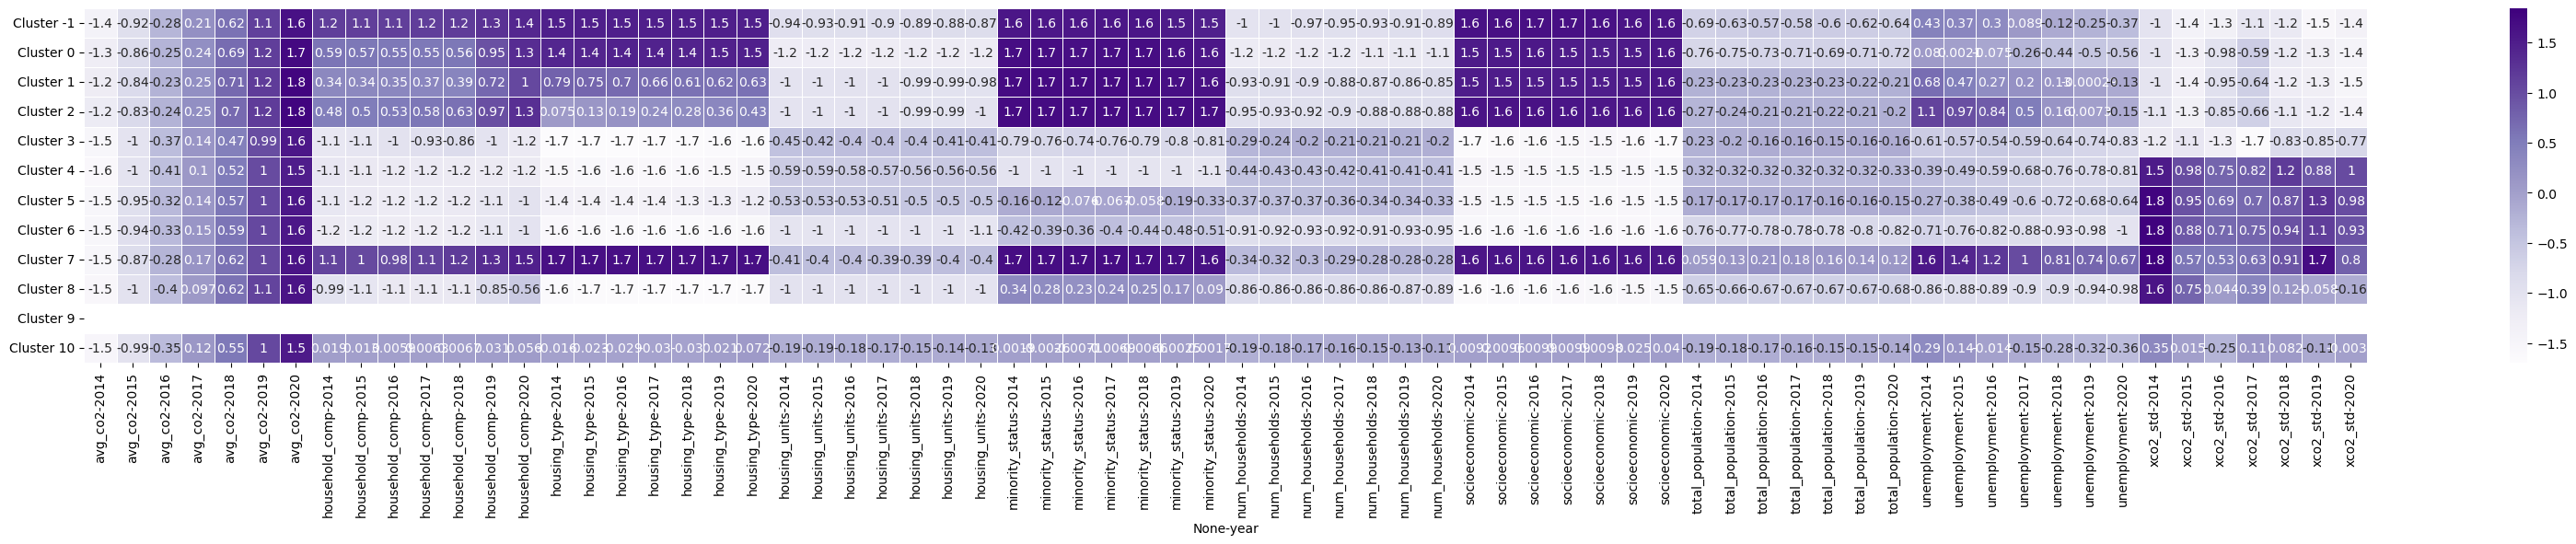

In [69]:
plt.figure(figsize=(40,5))
sns.heatmap(Centroids_std, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()

## Functional Data Reduction

We utilize functional data reduction to run DBSCAN on characteristics of the dataset such as mean and slope

In [84]:
data.columns

Index(['longitude', 'latitude', 'FIPS', 'avg_co2', 'year', 'ST', 'STATE',
       'ST_ABBR', 'STCNTY', 'COUNTY', 'LOCATION', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std', 'co2_1yr_change', 'co2_6yr_change', 'co2_1yr_pct_change',
       'co2_6yr_pct_change', 'co2_5yr_pct_change', 'co2_4yr_pct_change',
       'co2_3yr_pct_change', 'co2_2yr_pct_change'],
      dtype='object')

In [99]:
fdr_subset = data[['FIPS', 'year', 'avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']].dropna(axis=0).reset_index()
fdr_subset.drop(['index'], axis=1, inplace=True)
fdr_subset

,FIPS,year,avg_co2,total_population,housing_units,num_households,unemployment,socioeconomic,household_comp,minority_status,housing_type,overall_svi,xco2_std
0,34005702808,2015,400.576686,3198.5,1113.0,1052.5,235.0,0.67105,0.72955,0.84655,0.15610,0.60690,2.817643
1,34005702808,2019,410.654556,3415.0,1138.5,1055.5,120.5,0.57505,0.75375,0.85460,0.06600,0.46885,2.893552
2,34005702808,2020,413.296552,3447.0,1141.0,1053.0,77.0,0.58480,0.68890,0.92850,0.07030,0.45420,2.789300
3,34005702808,2017,406.027738,3293.5,1129.5,1049.5,204.0,0.62985,0.77170,0.78970,0.10665,0.54330,2.733697
4,34005702808,2018,408.250298,3383.0,1136.0,1058.0,164.0,0.56530,0.81860,0.78070,0.06170,0.48350,2.722180
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481351,53061052112,2017,405.736608,2576.0,976.5,939.5,74.5,0.18965,0.17180,0.37645,0.27300,0.16750,2.442318
481352,53061052112,2015,399.888669,2677.5,963.0,922.0,90.5,0.17210,0.06920,0.35085,0.25950,0.11290,2.423822
481353,53061052112,2014,397.707731,2787.0,951.0,911.0,103.0,0.19010,0.05270,0.33040,0.27020,0.10710,2.478455
481354,53061052112,2018,408.005867,2584.0,978.0,946.0,71.0,0.22520,0.25790,0.38160,0.29720,0.21630,2.311026


In [101]:


# initialize scaler
scaler = StandardScaler()

scaled_fdr_subset = fdr_subset.copy()


# scale the data
scaled_fdr_subset[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']] = scaler.fit_transform(scaled_fdr_subset[['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']])


In [102]:
scaled_fdr_subset = scaled_fdr_subset[['FIPS', 'year', 'avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']].pivot_table(index='FIPS', columns='year')
scaled_fdr_subset

avg_co2                                                    \
year             2014      2015      2016      2017      2018      2019   
FIPS                                                                      
1001020100  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020200  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020300  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020400  -1.544820 -1.000387 -0.360496  0.026080  0.462927  1.011611   
1001020500  -1.544820 -1.000387 -0.360496  0.026080  0.462927       NaN   
...               ...       ...       ...       ...       ...       ...   
56043000200 -1.649210 -1.105089 -0.469222  0.086112  0.486832  0.947617   
56043000301 -1.600983 -1.086264 -0.485262  0.063353  0.481001  0.910583   
56043000302 -1.600983 -1.086264 -0.485262  0.063353  0.481001  0.910583   
56045951100 -1.620393 -1.088173 -0.422281  0.048533  0.432003  0.956676   
56045951300 -1.620393 -1.088173 -0.422281  0.048533  0.432003  0.956676   

                      household_comp                      ... unemployment  \
year             2020           2014      2015      2016  ...         2018   
FIPS                                                      ...                
1001020100   1.522620      -0.587399 -0.773455 -0.959510  ...    -1.031834   
1001020200   1.522620      -0.575693 -0.078008  0.419677  ...    -1.031834   
1001020300   1.522620       1.301534  0.972522  0.643511  ...    -0.855787   
1001020400   1.522620       1.047548  1.054820  1.062092  ...    -0.908601   
1001020500        NaN      -0.157468 -0.234799 -0.312130  ...    -0.459683   
...               ...            ...       ...       ...  ...          ...   
56043000200  1.483628       0.863798  0.804913  0.746028  ...    -0.574113   
56043000301  1.463606       1.577513  1.624692  1.671871  ...    -0.890996   
56043000302  1.463606       0.697075  0.931729  1.166382  ...    -0.327648   
56045951100  1.428145      -0.910203 -0.757670 -0.605136  ...    -1.181473   
56045951300  1.428145       1.144034  1.029102  0.914169  ...    -0.468485   

                                 xco2_std                                \
year             2019      2020      2014      2015      2016      2017   
FIPS                                                                      
1001020100  -1.106653 -1.181473 -0.313313 -0.408688 -1.850916 -0.025444   
1001020200  -1.058241 -1.084647 -0.313313 -0.408688 -1.850916 -0.025444   
1001020300  -0.864589 -0.873392 -0.313313 -0.408688 -1.850916 -0.025444   
1001020400  -0.952613 -0.996624 -0.313313 -0.408688 -1.850916 -0.025444   
1001020500        NaN       NaN -0.313313 -0.408688 -1.850916 -0.025444   
...               ...       ...       ...       ...       ...       ...   
56043000200 -0.736956 -0.899799 -0.924118 -1.414229 -1.446534 -1.352113   
56043000301 -0.979020 -1.067043 -0.784703 -1.088227 -1.263206 -1.302125   
56043000302 -0.442078 -0.556508 -0.784703 -1.088227 -1.263206 -1.302125   
56045951100 -1.075845 -0.970217 -0.486595 -1.456308 -0.485829 -0.662472   
56045951300 -0.569712 -0.670938 -0.486595 -1.456308 -0.485829 -0.662472   

                                           
year             2018      2019      2020  
FIPS                                       
1001020100  -0.158256 -0.999227 -0.857332  
1001020200  -0.158256 -0.999227 -0.857332  
1001020300  -0.158256 -0.999227 -0.857332  
1001020400  -0.158256 -0.999227 -0.857332  
1001020500  -0.158256       NaN       NaN  
...               ...       ...       ...  
56043000200 -0.862826 -0.984752 -0.812978  
56043000301 -0.623026 -1.403949 -0.408707  
56043000302 -0.623026 -1.403949 -0.408707  
56045951100 -0.663084 -1.027656 -0.898625  
56045951300 -0.663084 -1.027656 -0.898625  

[72062 rows x 77 columns]

In [103]:
# Create a placeholder for preprocessing
columns = ['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']
features = ['Mean','Slope']

my_column = pd.MultiIndex.from_product([features,columns],
                                     names=('features','columns'))

preprocess_df = pd.DataFrame(index = scaled_fdr_subset.index,
                       columns=my_column)

preprocess_df

features       Mean                                                \
columns     avg_co2 total_population housing_units num_households   
FIPS                                                                
1001020100      NaN              NaN           NaN            NaN   
1001020200      NaN              NaN           NaN            NaN   
1001020300      NaN              NaN           NaN            NaN   
1001020400      NaN              NaN           NaN            NaN   
1001020500      NaN              NaN           NaN            NaN   
...             ...              ...           ...            ...   
56043000200     NaN              NaN           NaN            NaN   
56043000301     NaN              NaN           NaN            NaN   
56043000302     NaN              NaN           NaN            NaN   
56045951100     NaN              NaN           NaN            NaN   
56045951300     NaN              NaN           NaN            NaN   

features                                                               \
columns     unemployment socioeconomic household_comp minority_status   
FIPS                                                                    
1001020100           NaN           NaN            NaN             NaN   
1001020200           NaN           NaN            NaN             NaN   
1001020300           NaN           NaN            NaN             NaN   
1001020400           NaN           NaN            NaN             NaN   
1001020500           NaN           NaN            NaN             NaN   
...                  ...           ...            ...             ...   
56043000200          NaN           NaN            NaN             NaN   
56043000301          NaN           NaN            NaN             NaN   
56043000302          NaN           NaN            NaN             NaN   
56045951100          NaN           NaN            NaN             NaN   
56045951300          NaN           NaN            NaN             NaN   

features                              ...            Slope                \
columns     housing_type overall_svi  ... total_population housing_units   
FIPS                                  ...                                  
1001020100           NaN         NaN  ...              NaN           NaN   
1001020200           NaN         NaN  ...              NaN           NaN   
1001020300           NaN         NaN  ...              NaN           NaN   
1001020400           NaN         NaN  ...              NaN           NaN   
1001020500           NaN         NaN  ...              NaN           NaN   
...                  ...         ...  ...              ...           ...   
56043000200          NaN         NaN  ...              NaN           NaN   
56043000301          NaN         NaN  ...              NaN           NaN   
56043000302          NaN         NaN  ...              NaN           NaN   
56045951100          NaN         NaN  ...              NaN           NaN   
56045951300          NaN         NaN  ...              NaN           NaN   

features                                                              \
columns     num_households unemployment socioeconomic household_comp   
FIPS                                                                   
1001020100             NaN          NaN           NaN            NaN   
1001020200             NaN          NaN           NaN            NaN   
1001020300             NaN          NaN           NaN            NaN   
1001020400             NaN          NaN           NaN            NaN   
1001020500             NaN          NaN           NaN            NaN   
...                    ...          ...           ...            ...   
56043000200            NaN          NaN           NaN            NaN   
56043000301            NaN          NaN           NaN            NaN   
56043000302            NaN          NaN           NaN            NaN   
56045951100            NaN          NaN           NaN            NaN   
560459513

In [105]:
from sklearn.linear_model import LinearRegression

columns = ['avg_co2', 'total_population',
       'housing_units', 'num_households', 'unemployment', 'socioeconomic',
       'household_comp', 'minority_status', 'housing_type', 'overall_svi',
       'xco2_std']

for FIP in preprocess_df.index:
    for col in columns:
        preprocess_df.loc[FIP,('Mean',col)] = scaled_fdr_subset.loc[FIP,col].mean()
        preprocess_df.loc[FIP,('Slope',col)] = scaled_fdr_subset.loc[FIP,col].diff().mean()
preprocess_df

features         Mean                                                \
columns       avg_co2 total_population housing_units num_households   
FIPS                                                                  
1001020100   0.016791        -1.157485     -1.316899      -1.202232   
1001020200   0.016791        -1.089423     -1.203452      -1.185033   
1001020300   0.016791        -0.449258      -0.48824      -0.455733   
1001020400   0.016791        -0.112528      0.052747       0.125859   
1001020500  -0.483339         3.018837      3.250484       3.601381   
...               ...              ...           ...            ...   
56043000200 -0.031333        -0.564345     -0.444902      -0.408856   
56043000301 -0.036281        -0.899178     -0.675719      -0.643242   
56043000302 -0.036281        -0.839931      -0.86006       -0.79891   
56045951100 -0.037927        -0.486063     -0.207718      -0.264195   
56045951300 -0.037927        -0.254799      0.080128       0.030827   

features                                                               \
columns     unemployment socioeconomic household_comp minority_status   
FIPS                                                                    
1001020100     -1.019259     -0.306831      -0.343954        -0.45834   
1001020200     -0.703004      0.725222      -0.475812        0.514466   
1001020300     -0.785997      -0.05676       1.106331        0.268155   
1001020400     -0.269175     -0.648701       1.055478       -0.414936   
1001020500     -0.327648     -0.968032      -0.021393       -0.383599   
...                  ...           ...            ...             ...   
56043000200    -0.705519     -0.469383        0.45254        -0.95206   
56043000301    -0.628813      0.163159       1.075267       -0.525178   
56043000302    -0.335822      0.518339       0.909381       -0.226189   
56045951100    -1.066414     -0.595737      -0.311445       -1.111191   
56045951300    -0.545191     -0.140499       0.322101       -0.745288   

features                              ...            Slope                \
columns     housing_type overall_svi  ... total_population housing_units   
FIPS                                  ...                                  
1001020100     -1.224055    -0.84319  ...          0.00336     -0.000814   
1001020200      1.027806    0.711577  ...        -0.047939     -0.027468   
1001020300     -0.508808     0.19087  ...         0.032533      0.011191   
1001020400     -1.497702   -0.842346  ...        -0.060067      -0.02584   
1001020500       0.10655   -0.499368  ...        -0.122674       0.01465   
...                  ...         ...  ...              ...           ...   
56043000200     1.126307    0.101767  ...        -0.013439      0.022788   
56043000301     0.237518    0.381819  ...        -0.036712     -0.021364   
56043000302     0.433091    0.603297  ...         0.008277      0.006307   
56045951100      1.01728   -0.220414  ...        -0.008768     -0.024009   
56045951300     1.075854    0.262535  ...        -0.007047      0.034386   

features                                                              \
columns     num_households unemployment socioeconomic household_comp   
FIPS                                                                   
1001020100        0.001147    -0.044012      0.010391       0.099088   
1001020200       -0.051365    -0.200986     -0.162767      -0.155253   
1001020300        0.032333    -0.019072     -0.085389      -0.005676   
1001020400       -0.015364    -0.250866     -0.114761       0.007035   
1001020500        0.003096    -0.180448      0.084721       0.164949   
...                    ...          ...           ...            ...   
56043000200       0.008714    -0.027874      0.002032      -0.247897   
56043000301      -0.025453    -0.168711     -0.111859      -0.277989   
56043000302       0.011236    -0.042545      0.066755      -0.037542   
56045951100            0.0    -0.036676       0.15197

In [109]:
preprocess_df.dropna(axis=0, inplace=True)

In [110]:
preprocess_df_sample = preprocess_df.sample(45000)

In [111]:
# Epsilon values
x = np.linspace(.025, 2.0, 10)

# Min core points
min_samples = list(range(5,16))

epsilon = []
m_samples = []
sil_scores = []
n_clusters = []


for eps in x:
    for samples in min_samples:
        df_copy = preprocess_df_sample.copy()
        # fit dbscan model
        dbscan = DBSCAN(eps = eps, min_samples = samples)
        dbscan.fit(df_copy)

        # add cluster labels to df
        df_copy['Cluster']=dbscan.labels_
        labels = dbscan.labels_
        n_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in labels else 0))
        # print(n_clusters)

        # measure silhouette score
        if n_clusters[-1] == 0:
            sil_scores.append(0)
        else:
            sil_scores.append(metrics.silhouette_score(df_copy, labels))
        epsilon.append(eps)
        m_samples.append(samples)

In [112]:
dbscan_preprocess_df_sample = pd.DataFrame(data={'Epsilon': epsilon, 'Min_samples': m_samples, 'Silhouette Scores': sil_scores, 'Num of Clusters': n_clusters})

# Epsilon, Min_samples at max silhouette score
dbscan_preprocess_df_sample.loc[dbscan_preprocess_df_sample['Silhouette Scores'].idxmax()]

Epsilon              2.000000
Min_samples          5.000000
Silhouette Scores    0.640968
Num of Clusters      1.000000
Name: 99, dtype: float64

In [113]:
print(dbscan_preprocess_df_sample.to_string())

      Epsilon  Min_samples  Silhouette Scores  Num of Clusters
0    0.025000            5           0.000000                0
1    0.025000            6           0.000000                0
2    0.025000            7           0.000000                0
3    0.025000            8           0.000000                0
4    0.025000            9           0.000000                0
5    0.025000           10           0.000000                0
6    0.025000           11           0.000000                0
7    0.025000           12           0.000000                0
8    0.025000           13           0.000000                0
9    0.025000           14           0.000000                0
10   0.025000           15           0.000000                0
11   0.244444            5           0.000000                0
12   0.244444            6           0.000000                0
13   0.244444            7           0.000000                0
14   0.244444            8           0.000000          

In [119]:
dbscan_fdr = preprocess_df.copy()
dbscan = DBSCAN(eps = 1.561111, min_samples = 5)
dbscan.fit(dbscan_fdr)
# add cluster labels to df
dbscan_fdr['Cluster']=dbscan.labels_
labels = dbscan.labels_
n_clusters=len(set(dbscan.labels_)) - (1 if -1 in labels else 0)
print(n_clusters)

# measure silhouette score
sil_dbscan_fdr_df = metrics.silhouette_score(dbscan_fdr, labels)
print(sil_dbscan_fdr_df)

2
0.550417448695937


In [120]:
clusters = ['Cluster {}'.format(i) for i in range(-1,2)]
memb =  pd.Series(labels, index=preprocess_df.index)
# Centroids_orig = pd.DataFrame(0.0, index = clusters,columns = preprocess_df.columns)

Centroids_std = pd.DataFrame(0.0, index =  clusters,
                        columns = preprocess_df.columns)
for i in range(-1,2):
    BM = memb==i
    # Centroids_orig.iloc[i] = preprocess_df[BM].median(axis=0)
    Centroids_std.iloc[i] = preprocess_df[BM].mean(axis=0)

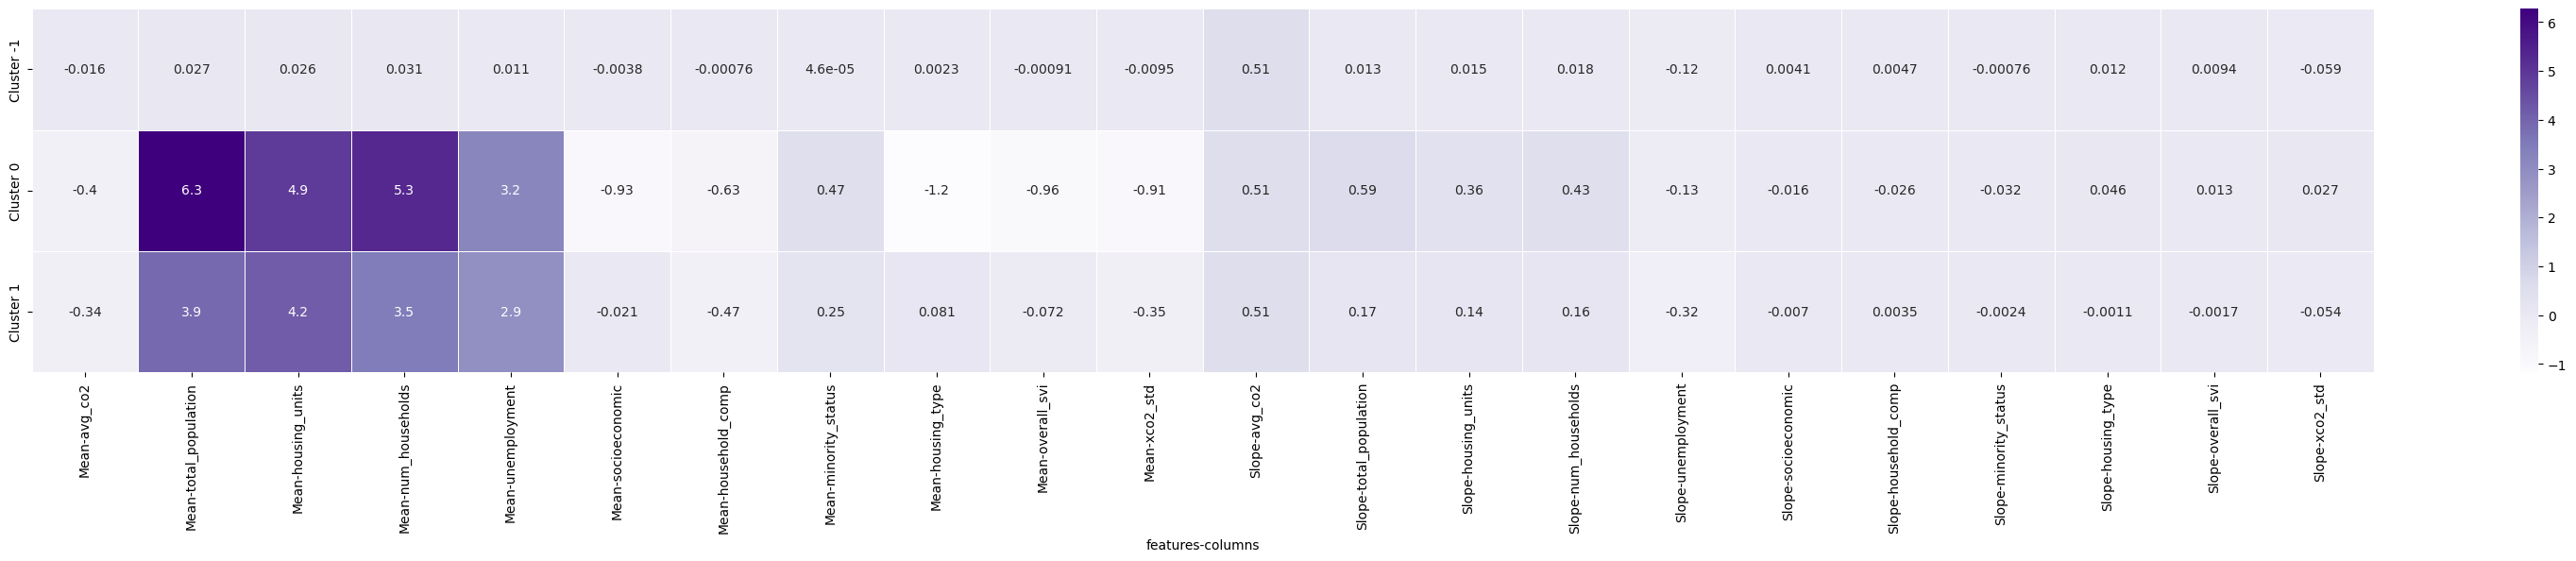

In [121]:
plt.figure(figsize=(40,5))
sns.heatmap(Centroids_std, linewidths=.5, annot=True, 
                    cmap='Purples')
plt.show()